In [ ]:
# INSTALL MODULES

%pip install pickle5

# IMPORTS
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import os
import pickle5 as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

# Mount Google Drive in Colab
#from google.colab import files
from google.colab import drive
drive.mount("/content/gdrive")

# Import modules in Colab from other notebooks
%run '/content/gdrive/MyDrive/Colab Notebooks/training/dataset.ipynb'
%run '/content/gdrive/MyDrive/Colab Notebooks/training/models.ipynb'

if not torch.cuda.is_available():
    raise RuntimeError("You should enable GPU runtime.")



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# To speed up training, it's better to copy dataset from Drive to a Colab folder

# choose a local (colab) directory to store the data.
local_dataset_path = os.path.expanduser('/content/data')
try:
  os.makedirs(local_dataset_path)
except: pass

dataset_path = '/content/gdrive/MyDrive/jester_dataset'

!cp -avr "{dataset_path}" "{local_dataset_path}"

# Make sure it's there
!ls -lha /content/gdrive/MyDrive/jester_dataset/features

'/content/gdrive/MyDrive/jester_dataset/features/features_flow.pickle' -> '/content/data/jester_dataset/features/features_flow.pickle'
'/content/gdrive/MyDrive/jester_dataset/features/features_bad_videos.pickle' -> '/content/data/jester_dataset/features/features_bad_videos.pickle'
'/content/gdrive/MyDrive/jester_dataset/features/features_RGB.pickle' -> '/content/data/jester_dataset/features/features_RGB.pickle'
'/content/gdrive/MyDrive/jester_dataset/csv/validation.csv' -> '/content/data/jester_dataset/csv/validation.csv'
'/content/gdrive/MyDrive/jester_dataset/csv/train.csv' -> '/content/data/jester_dataset/csv/train.csv'
'/content/gdrive/MyDrive/jester_dataset/csv/labels.csv' -> '/content/data/jester_dataset/csv/labels.csv'
'/content/gdrive/MyDrive/jester_dataset/csv/train.gsheet' -> '/content/data/jester_dataset/csv/train.gsheet'
cp: cannot open '/content/gdrive/MyDrive/jester_dataset/csv/train.gsheet' for reading: Operation not supported
'/content/gdrive/MyDrive/jester_dataset/csv/

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Retrieves features from i3d_resnet50_v1_kinetics400 Gluon pre-trained model extracted from our 9 classes' Jester dataset videos
with open('/content/data/jester_dataset/features/features_RGB.pickle', 'rb') as handle:
    features_dict = pickle.load(handle)        # dict as {n_video:features, ...}  features: (1,2048)
    
csv_dir = '/content/data/jester_dataset/csv/'  # if in Google Cloud --> csv_dir = '/mnt/disks/disk-1/jester_dataset/dataset/csvs/' 
train_csv = csv_dir + 'train.csv' 
val_csv = csv_dir + 'validation.csv'
labels = csv_dir + 'labels.csv'

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, epoch):  
  model.train()
  accs, losses = [], []
  train_loop = tqdm(train_loader, unit=" batches")  # For printing the progress bar
  for features,labels in train_loop:
    train_loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch + 1, config["epochs"]))
    optimizer.zero_grad()
    features, labels = features.to(device), labels.to(device)
    output = model(features)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    accs.append(accuracy(labels, output))
    losses.append(loss.item())
    train_loop.set_postfix(loss=np.mean(losses), accuracy=np.mean(accs))
  return np.mean(losses), np.mean(accs)

In [ ]:
def eval_epoch(model, val_loader, criterion, epoch): 
  with torch.no_grad():
    model.eval()
    accs, losses = [], []
    val_loop = tqdm(val_loader, unit=" batches")  # For printing the progress bar
    for features, labels in val_loop:
      val_loop.set_description('[  VAL] Epoch {}/{}'.format(epoch + 1, config["epochs"]))
      features, labels = features.to(device), labels.to(device)
      output = model(features)
      loss = criterion(output, labels)
      accs.append(accuracy(labels, output))
      losses.append(loss.item())
      val_loop.set_postfix(loss=np.mean(losses), accuracy=np.mean(accs))
    return np.mean(losses), np.mean(accs)

In [ ]:
def accuracy(labels, outputs):
    preds = outputs.argmax(-1)
    acc = (preds == labels.view_as(preds)).cpu().float().detach().numpy().mean()
    return acc

In [ ]:
def train_model(config):
  # DATASETS
  train_dataset = JesterDatasetOneStream(features_dict, train_csv, labels)
  validation_dataset = JesterDatasetOneStream(features_dict, val_csv, labels)

  train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
  validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=False)

  # MODEL
  model = ClassifierOneStream().to(device)
  optimizer = optim.Adam(model.parameters(), lr = config['lr'])

  counts = pd.read_csv(train_csv).Action.value_counts()       # Counts = list of video counts for each class
  weights = torch.tensor([max(counts)/x for x in counts])     # calculates weights for all classes in training dataset (weight regularization)
  criterion = nn.CrossEntropyLoss(weight=weights).to(device)  # assigns weight to each of the classes. This is particularly useful when you have an unbalanced training set
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []
  for epoch in range(config['epochs']):
    
    loss, acc = train_epoch(model, train_loader, optimizer, criterion, epoch)
    train_losses.append(loss)
    train_accs.append(acc)
    
    loss, acc = eval_epoch(model, validation_loader, criterion, epoch)
    val_losses.append(loss)
    val_accs.append(acc)

  # Saves the model_state_dict to load it later in the final system's model to do inference 
  savedir = '/content/gdrive/MyDrive/model/state_dict.pt'
  print(f"Saving checkpoint to {savedir}...")
  checkpoint = {
      "model_state_dict": model.cpu().state_dict(),
  }
  torch.save(checkpoint, savedir)
  
  return model, [train_losses, train_accs, val_losses, val_accs]

[  VAL] Epoch 20/20: 100%|██████████| 172/172 [00:03<00:00, 45.85 batches/s, accuracy=0.719, loss=0.736]


Saving checkpoint to /content/gdrive/MyDrive/model/state_dict.pt...
Training finished


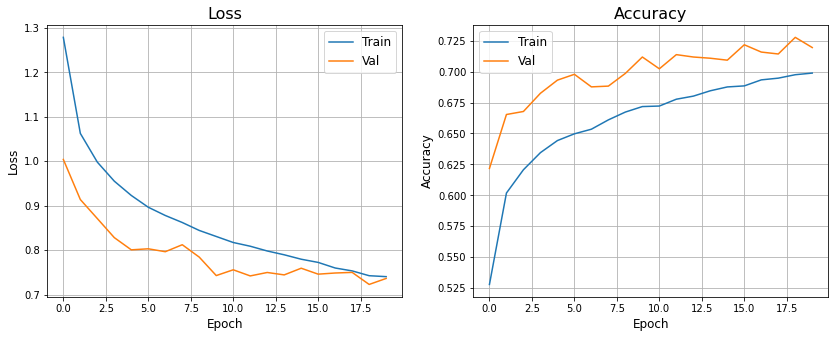

In [ ]:
if __name__ == "__main__":

    config = {
        'lr': 1e-3,
        'batch_size': 32,
        'epochs': 20,
    }
    trained_model, metrics = train_model(config)

    print("Training finished")

    # Calculates accuracy and lost graphs

    fig = plt.figure(figsize=[14,5])
    plt.subplot(1, 2, 1)
    plt.plot(metrics[0],label='Train')
    plt.plot(metrics[2],label='Val')
    plt.legend(fontsize=12)
    plt.title('Loss',fontsize=16)
    plt.grid()
    plt.xlabel('Epoch',fontsize=12)
    plt.ylabel('Loss',fontsize=12)
    plt.subplot(1, 2, 2)
    plt.plot(metrics[1],label='Train')
    plt.plot(metrics[3],label='Val')
    plt.title('Accuracy',fontsize=16)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xlabel('Epoch',fontsize=12)
    plt.ylabel('Accuracy',fontsize=12)



Text(0.5, 42.0, 'Predicted label')

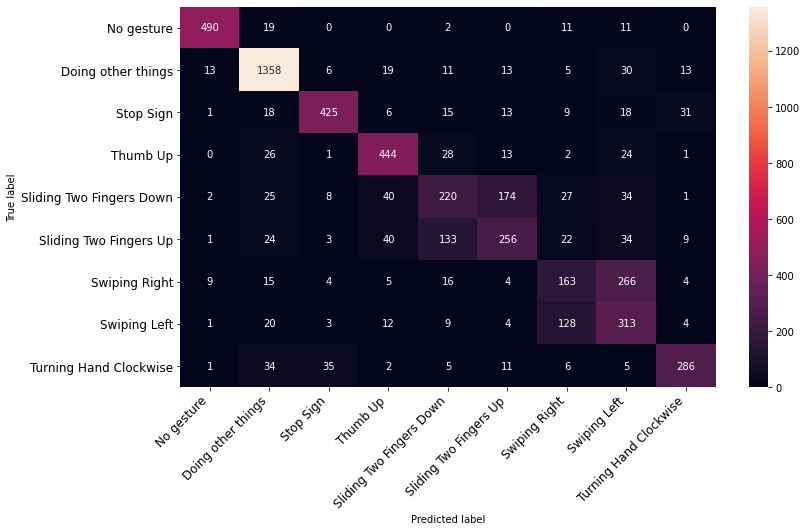

In [ ]:
import seaborn as sns

# Calculates confusion matrix and accuracy for each class

validation_dataset = JesterDatasetOneStream(features_dict,val_csv,labels)
validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=False)
nb_classes = 9
confusion_matrix = np.zeros((nb_classes, nb_classes))
trained_model = trained_model.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validation_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(12,7))

l = pd.read_csv(labels)
class_names = list(l['Actions'])
l['Accuracy'] = np.diag(confusion_matrix)/confusion_matrix.sum(1)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
# Show the accuracy for each class
l

,Actions,Accuracy
0,No gesture,0.919325
1,Doing other things,0.925068
2,Stop Sign,0.792910
3,Thumb Up,0.823748
4,Sliding Two Fingers Down,0.414313
5,Sliding Two Fingers Up,0.490421
6,Swiping Right,0.335391
7,Swiping Left,0.633603
8,Turning Hand Clockwise,0.742857
